In [1]:
import sys
from data import RecordStore, Record
import numpy as np
from typing import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn
import matplotlib.pyplot as plt


In [2]:
RecordStore.load()
RecordStore.load_w2v()

len(RecordStore.classes), RecordStore.classes

(15,
 ['P', 'D', 'Q', 'K', 'E', 'H', 'F', 'T', 'S', 'R', 'G', 'B', 'N', 'L', 'J'])

In [3]:
class LSTM_Classifier(torch.nn.Module):
    def __init__(self) -> None:
        super(LSTM_Classifier, self).__init__()
        num_layers = 2
        batch_size = 1
        hidden_size = 300
        # h0 = torch.randn(num_layers, batch_size, hidden_size)
        # c0 = torch.randn(num_layers, batch_size, hidden_size)
        self.lstm = torch.nn.LSTM(input_size=300, hidden_size=hidden_size, num_layers=num_layers, batch_first=True).cuda()
        self.clf = nn.Sequential(nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, len(RecordStore.classes))
            ).cuda()
        # self.clf = torch.nn.Linear(hidden_size, len(RecordStore.classes)).cuda()

    def _get_last_timesteps(self, lstm_out):
        padded_seq, lengths = rnn.pad_packed_sequence(lstm_out, batch_first=True)
        last_timesteps = []
        for i in range(len(padded_seq)):
            last_timesteps.append(padded_seq[i, lengths[i]-1])
        return torch.stack(last_timesteps, dim=0)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_timesteps = self._get_last_timesteps(lstm_out)
        clf_out = self.clf(last_timesteps)
        scores = F.log_softmax(clf_out, dim=1)
        return scores
    
    def predict(self, x):
        assert type(x) == torch.Tensor, "expected a single tensor"
        assert len(x.shape) == 2, "expected a tensor with 2 dimensions"
        x = rnn.pack_sequence([x])
        out = self.forward(x).squeeze(0)
        return torch.argmax(out)

In [4]:
X, Y = [], []
for record in RecordStore.train_records:
    embedding = record.synopsis_embeddings_w2v
    X.append(torch.from_numpy(embedding).cuda())
    Y.append(record.cls_idx)

LABEL: 12


In [6]:
def sort_XY(X, Y):
    to_be_sorted = [(x,y) for x,y in zip(X,Y)]
    to_be_sorted.sort(reverse=True, key=lambda x: x[0].shape[0])
    X, Y = [], []
    for (x,y) in to_be_sorted:
        X.append(x)
        Y.append(y)
    return X, Y

X, Y = sort_XY(X, Y)
Y = torch.tensor(Y).cuda()

In [14]:
def accuracy(model: nn.Module, X, Y):
    mode = model.training
    model.eval()
    count = 0
    with torch.no_grad():
        for x, y in zip(X,Y):
            if model.predict(x) == y:
                count += 1
    print('count, len:', count, len(X))
    model.train(mode)
    return count / len(X)

In [22]:
model = LSTM_Classifier().cuda()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.NLLLoss()

In [23]:
# Training
losses = []
batch_size = 64
for epoch in range(30):
    print('epoch:', epoch)
    n_steps = int(len(X)/batch_size)
    for i in range(n_steps):
        inp = X[i*batch_size:(i+1)*batch_size]
        inp = rnn.pack_sequence(inp)
        labels = Y[i*batch_size:(i+1)*batch_size]
        model.zero_grad()
        out = model(inp)
        # print('out shape')
        # print(out.shape)
        loss = loss_function(out, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()

        if i % 100 == 0:
            print('{}/{}'.format(i, n_steps))
            print('loss:{}'.format(loss.item()))


epoch: 0
0/398
loss:2.7061119079589844
100/398
loss:2.0975823402404785
200/398
loss:1.7310750484466553
300/398
loss:1.5712765455245972
epoch: 1
0/398
loss:5.614026069641113
100/398
loss:1.3232722282409668
200/398
loss:1.2466171979904175
300/398
loss:1.2859865427017212
epoch: 2
0/398
loss:2.5119595527648926
100/398
loss:1.1264742612838745
200/398
loss:1.015842318534851
300/398
loss:1.077006459236145
epoch: 3
0/398
loss:1.8404788970947266
100/398
loss:1.0607014894485474
200/398
loss:0.831504762172699
300/398
loss:0.9207471609115601
epoch: 4
0/398
loss:1.3429574966430664
100/398
loss:0.9181041717529297
200/398
loss:0.7094770669937134
300/398
loss:0.7896018028259277
epoch: 5
0/398
loss:1.0968928337097168
100/398
loss:0.9007744193077087
200/398
loss:0.6188061237335205
300/398
loss:0.7113907337188721
epoch: 6
0/398
loss:0.9478774666786194
100/398
loss:0.8098680377006531
200/398
loss:0.5677005648612976
300/398
loss:0.6003221869468689
epoch: 7
0/398
loss:0.8361952900886536
100/398
loss:0.70705

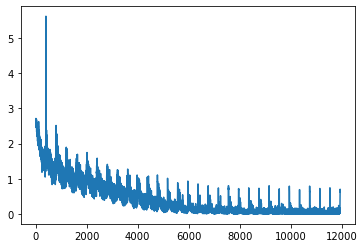

In [24]:
plt.plot(losses)

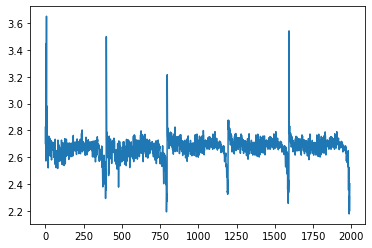

In [12]:
# an old loss
plt.plot(losses)

In [25]:
accuracy(model, X, Y)

count, len: 24918 25526


0.9761811486327666

In [26]:
# Prepare test data
X_test, Y_test = [], []
for record in RecordStore.test_records:
    embedding = record.synopsis_embeddings_w2v
    X_test.append(torch.from_numpy(embedding).cuda())
    Y_test.append(record.cls_idx)
Y_test = torch.tensor(Y_test)

In [27]:
accuracy(model, X_test, Y_test)

count, len: 2054 3000


0.6846666666666666